In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import abc
from datetime import datetime
from uuid import uuid4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import statsmodels.api as sm
from io import FileIO, BytesIO, StringIO

sys.path.append('..')
from src.models.supervised.regression.crosssection.linear_models.OLS import OLS

In [37]:
my_model = OLS()

In [38]:
X = np.random.multivariate_normal([0, 0], [[3, 0.9], [0.9, 3]], 156)
y = X.dot([0.4, 0.6]) + np.random.normal(0, 1, 156)
data = np.vstack([X.T, y]).T
df = pd.DataFrame(data, columns=["X1", "X2", "y"])
df.corr().style.background_gradient(cmap='coolwarm')

,X1,X2,y
X1,1.000000,0.227342,0.565312
X2,0.227342,1.000000,0.676830
y,0.565312,0.676830,1.000000


In [39]:
sm_model = sm.OLS(y, sm.add_constant(X)).fit()

In [40]:
my_model.fit(df[['X1', 'X2']], df['y'])

In [41]:
from zipfile import ZipFile

In [49]:
test = my_model.save()

In [50]:
with open('test.zip', 'wb') as f:
    f.write(test.getvalue())

In [26]:
loaded_model = OLS()

In [45]:
loaded_model.load("ols_test.zip")

In [46]:
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     134.0
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           2.34e-34
Time:                        19:44:44   Log-Likelihood:                -230.17
No. Observations:                 156   AIC:                             466.3
Df Residuals:                     153   BIC:                             475.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0246      0.087     -0.282      0.778      -0.197       0.148
X1             0.4749      0.055      8.669      0.000       0.367       0.583
X2             0.5884      0.051     11.553      0.000       0.488       0.689
==============================================================================
Omnibus:                        4.742   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                2.683
Skew:                           0.041   Prob(JB):                        0.261
Kurtosis:                       2.363   Cond. No.                         1.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     134.0
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           2.34e-34
Time:                        19:44:45   Log-Likelihood:                -230.17
No. Observations:                 156   AIC:                             466.3
Df Residuals:                     153   BIC:                             475.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0246      0.087     -0.282      0.778      -0.197       0.148
X1             0.4749      0.055      8.669      0.000       0.367       0.583
X2             0.5884      0.051     11.553      0.000       0.488       0.689
==============================================================================
Omnibus:                        4.742   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                2.683
Skew:                           0.041   Prob(JB):                        0.261
Kurtosis:                       2.363   Cond. No.                         1.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
import json
import pickle

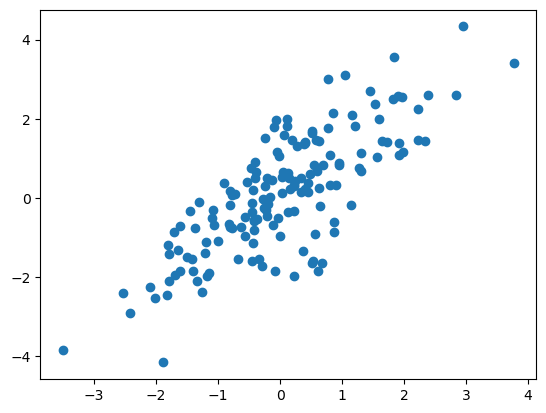

In [7]:
plt.scatter(my_model.predict(df[['X1', 'X2']]), df['y'])